In [1]:
from Utils import *

In [2]:
#dfs creation from npz
folder_path = r"C:\Users\stebi\Desktop\potatoes\1800"
dataframes = load_npz_files(folder_path)
for name, df in dataframes.items():
    globals()[name] = df

In [3]:
df1

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,97.256714,109.217660,108.177720,110.046720,111.929620,113.559700,115.110200,116.551600,117.922420,119.223114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-69
1,135.700580,135.549320,135.346160,135.170640,135.020170,134.848880,134.601290,134.442780,134.242870,134.050780,...,9.868005,9.852276,9.816974,9.782293,9.700430,9.679945,9.688729,9.622552,9.602593,-69
2,9.578903,9.526599,9.494160,9.464470,9.434893,9.427804,9.392871,9.344328,9.308388,9.259672,...,-16.482183,-16.470444,-16.422170,-16.474878,-16.486914,-16.491713,-16.491026,-16.491032,-16.503109,-69
3,-16.513840,-16.533766,-16.540901,-16.550737,-16.553303,-16.564280,-16.555020,-16.554382,-16.578356,-16.570112,...,-27.333277,-27.337494,-27.349640,-27.378326,-27.389366,-27.373075,-27.376266,-27.378641,-27.393843,-69
4,-27.412397,-27.448242,-27.443336,-27.450314,-27.465702,-27.474468,-27.468273,-27.471638,-27.469805,-27.470478,...,-34.502663,-34.514355,-34.519485,-34.522392,-34.513977,-34.524544,-34.507244,-34.500763,-34.506233,-69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,-43.059860,-43.060944,-43.066000,-43.049225,-43.058987,-43.070698,-43.051693,-43.047090,-43.051006,-43.048805,...,-43.122772,-43.127860,-43.137302,-43.132412,-43.117374,-43.118380,-43.153930,-43.136320,-43.122925,50
5707,-43.133860,-43.124810,-43.122246,-43.128620,-43.138603,-43.110493,-43.118230,-43.114530,-43.151154,-43.126816,...,-43.235577,-43.234085,-43.226307,-43.226593,-43.229260,-43.223568,-43.221080,-43.225350,-43.232190,50
5708,-43.236350,-43.258070,-43.237976,-43.241530,-43.243073,-43.243843,-43.235367,-43.222744,-43.216045,-43.243088,...,-43.249615,-43.250040,-43.256466,-43.232464,-43.207592,-43.221073,-43.214375,-43.218887,-43.213074,50
5709,-43.188545,-43.185560,-43.217820,-43.215878,-43.198994,-43.224888,-43.216103,-43.216553,-43.229237,-43.215015,...,-43.296200,-43.268800,-43.289883,-43.305720,-43.284767,-43.293180,-43.303246,-43.298733,-43.310486,50


In [4]:
df32

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1792,x1793,x1794,x1795,x1796,x1797,x1798,x1799,x1800,y
0,-30.770640,-33.980423,-33.078950,-33.179450,-33.302380,-33.306168,-33.294594,-33.294502,-33.338710,-33.266064,...,-33.484623,-33.714317,-33.754032,-33.524630,-33.390900,-33.321114,0.000000,0.000000,0.000000,-59
1,-33.245260,-33.207718,-33.295082,-33.540080,-33.527504,-33.440994,-33.426926,-33.365486,-33.541620,-33.428684,...,-32.730686,-32.684280,-32.648304,-32.638073,-32.635494,-32.641150,-32.630640,-32.643383,-32.610977,-59
2,-32.593422,-30.358680,-33.401700,-32.515373,-32.535145,-32.539658,-32.561690,-32.559845,-32.545235,-32.540200,...,-32.178368,-32.169907,-32.189014,-32.172250,-32.202705,-32.187820,-32.210007,-32.214810,-32.220097,-59
3,-32.228676,-32.243935,-32.254295,-32.256145,-32.257114,-32.253850,-32.245630,-32.243748,-32.293728,-32.349915,...,-33.140785,-33.141865,-33.130280,-33.135790,-33.124660,-33.101360,-33.078793,-33.054066,-33.066067,-59
4,-33.066160,-33.029760,-33.026203,-32.998478,-32.999706,-33.005135,-32.985794,-33.013160,-32.967945,-32.974510,...,-35.932003,-35.923367,-35.931942,-35.923004,-35.917380,-35.909830,-35.693447,-35.689910,-35.799480,-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682,-46.202307,-46.202370,-46.202433,-46.202495,-46.202558,-46.202621,-46.202683,-46.202746,-46.202809,-46.202871,...,-46.314498,-46.314560,-46.314623,-46.314685,-46.314748,-46.314811,-46.314873,-46.314936,-46.314999,60
5683,-46.315061,-46.315124,-46.315187,-46.315249,-46.315312,-46.315375,-46.315437,-46.315500,-46.315562,-46.315625,...,-46.427251,-46.427314,-46.427377,-46.427439,-46.427502,-46.427565,-46.427627,-46.427690,-46.427753,60
5684,-46.427815,-46.427878,-46.427940,-46.428003,-46.428066,-46.428128,-46.428191,-46.428254,-46.428316,-46.428379,...,-46.540005,-46.540068,-46.540131,-46.540193,-46.540256,-46.540319,-46.540381,-46.540444,-46.540506,60
5685,-46.540569,-46.540632,-46.540694,-46.540757,-46.540820,-46.540882,-46.540945,-46.541008,-46.541070,-46.541133,...,-46.519726,-46.523857,-46.506245,-46.502632,-46.504677,-46.497433,-46.493725,-46.493202,-46.488330,60


In [5]:
#nans all dfs
dataframe_names = [f'df{i}' for i in range(1, 33)]
nan_report = {}

for name in dataframe_names:
    df = globals().get(name)
    if df is not None and isinstance(df, pd.DataFrame):
        nan_columns = df.columns[df.isna().any()].tolist()
        if nan_columns:
            nan_report[name] = nan_columns

if not nan_report:
    print("No nans.")
else:
    print("Nans in this df:")
    for name, columns in nan_report.items():
        print(f"{name} is column: {columns}")

No nans.


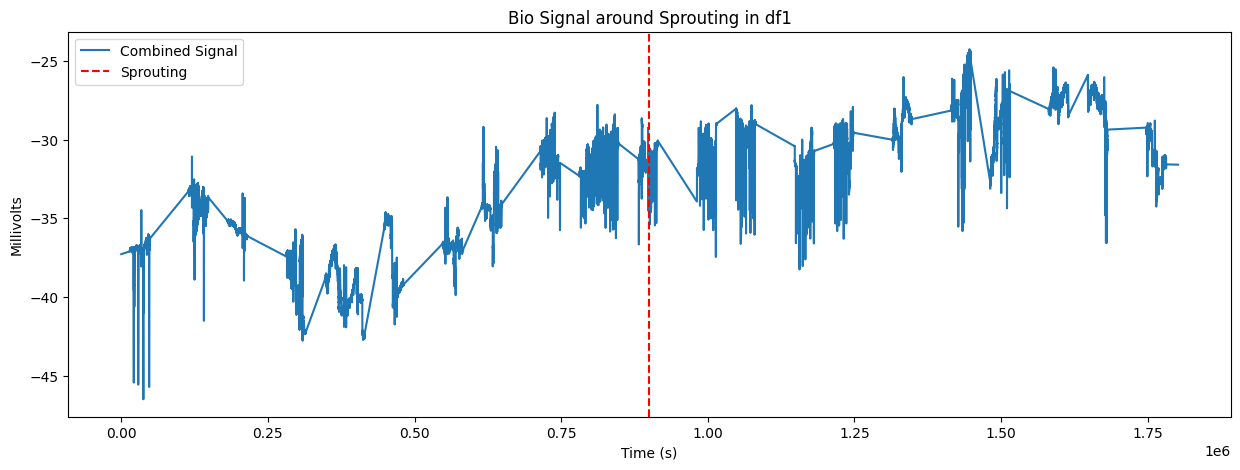

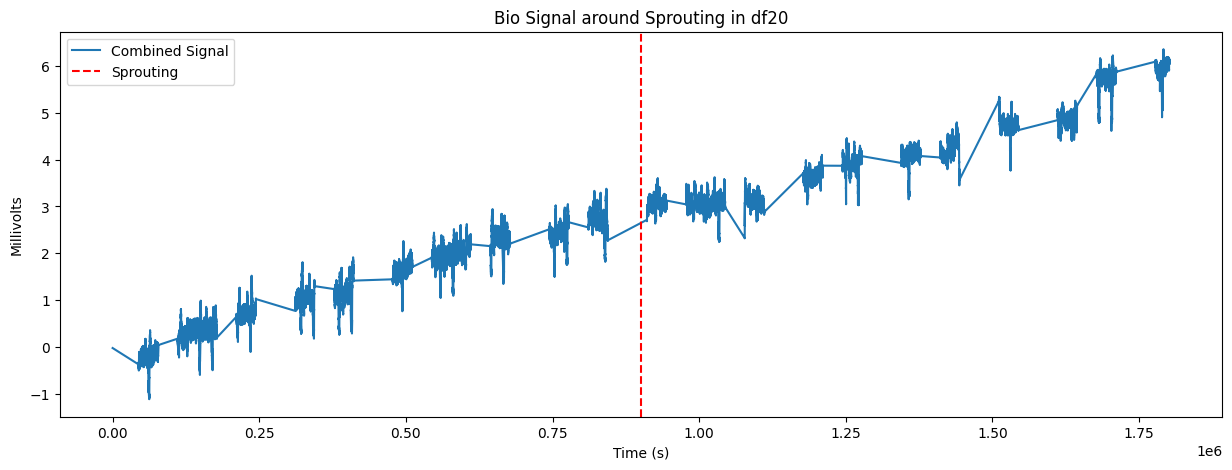

In [6]:
#500 steps before and after sprouting, see a pattern?
plot_bio_signal(df1, 'df1')
plot_bio_signal(df20, 'df20')

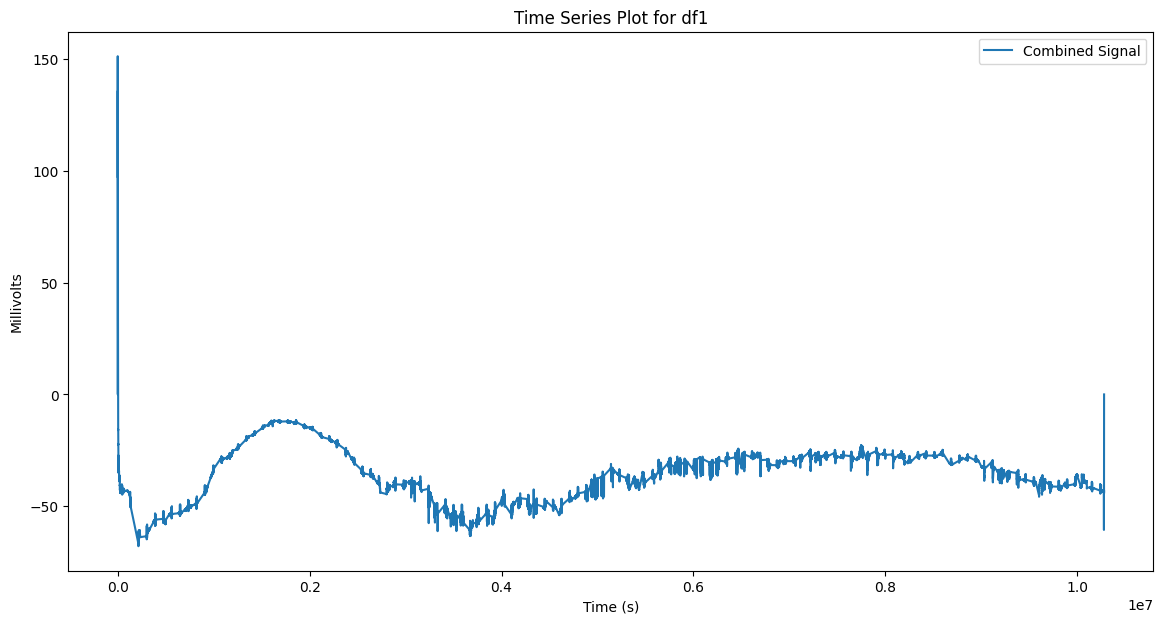

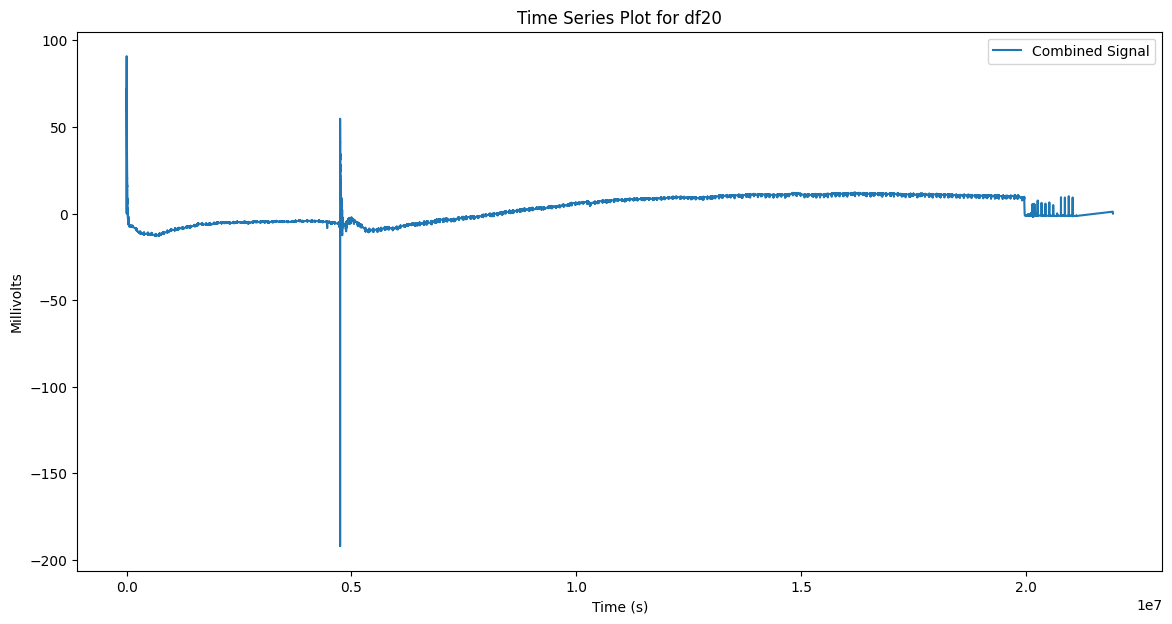

In [7]:
plot_time_series(df1, 'Time Series Plot for df1')
plot_time_series(df20, 'Time Series Plot for df20')

In [8]:
#keep only rows for y<=0
dataframe_names = [f'df{i}' for i in range(1, 33)]  

filtered_dataframes = {}

for name in dataframe_names:
    df = globals().get(name)  
    if df is not None and isinstance(df, pd.DataFrame):
        filtered_df = df.loc[df['y'] <= 0]
        filtered_dataframes[name] = filtered_df  
        print(f"First few rows of {name}:")
        print(filtered_df.head())  

First few rows of df1:
           x1          x2          x3          x4          x5          x6  \
0   97.256714  109.217660  108.177720  110.046720  111.929620  113.559700   
1  135.700580  135.549320  135.346160  135.170640  135.020170  134.848880   
2    9.578903    9.526599    9.494160    9.464470    9.434893    9.427804   
3  -16.513840  -16.533766  -16.540901  -16.550737  -16.553303  -16.564280   
4  -27.412397  -27.448242  -27.443336  -27.450314  -27.465702  -27.474468   

           x7          x8          x9         x10  ...      x1792      x1793  \
0  115.110200  116.551600  117.922420  119.223114  ...   0.000000   0.000000   
1  134.601290  134.442780  134.242870  134.050780  ...   9.868005   9.852276   
2    9.392871    9.344328    9.308388    9.259672  ... -16.482183 -16.470444   
3  -16.555020  -16.554382  -16.578356  -16.570112  ... -27.333277 -27.337494   
4  -27.468273  -27.471638  -27.469805  -27.470478  ... -34.502663 -34.514355   

       x1794      x1795      x179

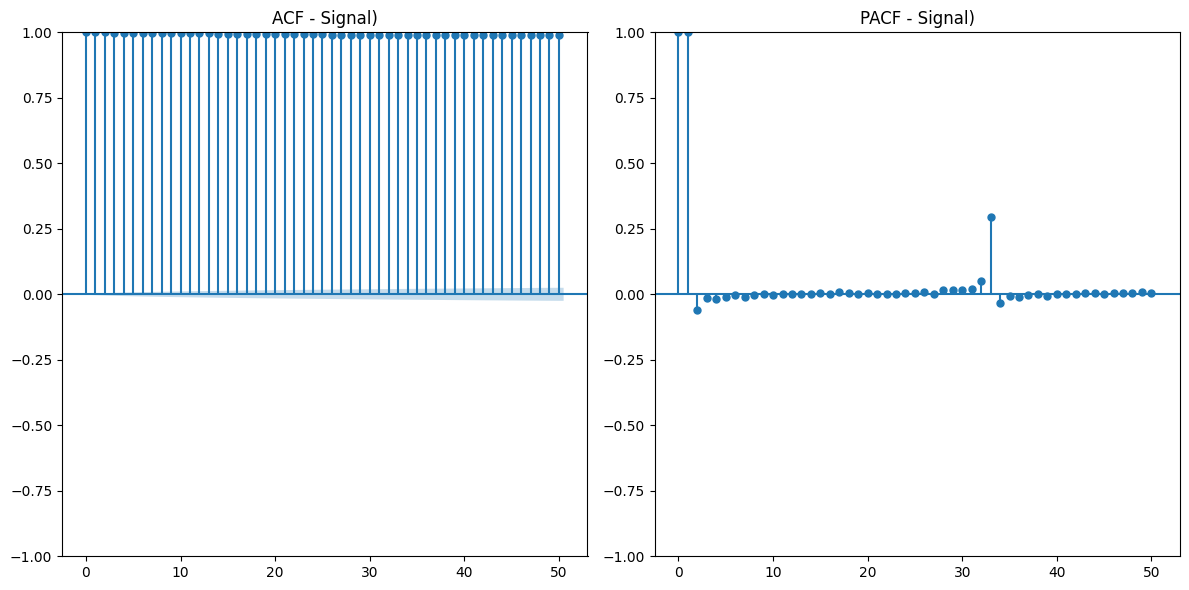

In [9]:
#ACF e PACF
filtered_df1 = df1.loc[df1['y'] <= 0]
combined_signal = filtered_df1.drop(columns='y', errors='ignore').values.flatten()
downsampled_signal = downsample_signal(combined_signal, factor=10) 
plot_acf_pacf(downsampled_signal, 'Signal)')

In [10]:
#check stationarity
stationarity_results_df1 = check_combined_stationarity_kpss(df1)
for key, value in stationarity_results_df1.items():
    print(f"{key}: {value}")

Test Statistic: 48.294028615659315
p-value: 0.01
Lags Used: 1724
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationarity: Non-stationary


c:\Users\stebi\Desktop\TESI\Thesis\Utils\stationarity.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(combined_signal, regression='c', nlags='auto')


In [11]:
#box-cox for normalization 
transformed_dataframes = {}
for name, df in filtered_dataframes.items():
    transformed_df = apply_box_cox(df, target='y')
    transformed_dataframes[name] = transformed_df 

In [ ]:
#anomaly detection +/- 4 stdev
cleaned_dataframes = {}

for name, df in transformed_dataframes.items():
    if df is not None and isinstance(df, pd.DataFrame):
        print(f"Processing {name} with shape {df.shape}")  
        try:
            cleaned_df = detect_replace_outliers(df)
            cleaned_dataframes[name] = cleaned_df 
            print(f"Outliers detected and replaced in {name}")
        except KeyError as e:
            print(f"KeyError encountered while processing {name}: {e}")
            print("DataFrame columns:", df.columns)
            print("DataFrame head:")
            print(df.head())
        except IndexError as e:
            print(f"IndexError encountered while processing {name}: {e}")


Processing df1 with shape (3337, 1801)
Outliers detected and replaced in df1
Processing df2 with shape (3685, 1801)
Outliers detected and replaced in df2
Processing df3 with shape (2185, 1801)
Outliers detected and replaced in df3
Processing df4 with shape (3253, 1801)
Outliers detected and replaced in df4
Processing df5 with shape (2041, 1801)
Outliers detected and replaced in df5
Processing df6 with shape (3073, 1801)
Outliers detected and replaced in df6
Processing df7 with shape (3001, 1801)
Outliers detected and replaced in df7
Processing df8 with shape (2665, 1801)
Outliers detected and replaced in df8
Processing df9 with shape (6956, 1801)
Outliers detected and replaced in df9
Processing df10 with shape (9796, 1801)
Outliers detected and replaced in df10
Processing df11 with shape (8664, 1801)
Outliers detected and replaced in df11
Processing df12 with shape (6872, 1801)
Outliers detected and replaced in df12
Processing df13 with shape (5513, 1801)
Outliers detected and replaced

In [ ]:
#detrend wavelet
detrended_dataframes_continuous = {}
detrended_dataframes_linear = {}

for name, df in cleaned_dataframes.items():
    detrended_df_continuous = detrend_signal_wavelet_cont(df)
    detrended_dataframes_continuous[name] = detrended_df_continuous
    detrended_df_linear = detrend_signal_wavelet_linear(df)
    detrended_dataframes_linear[name] = detrended_df_linear

In [ ]:
#plot detrended
#plot_detrended_signal(detrended_df1, 'df1')

In [ ]:
#feature generation
augmented_features_continuous = {}
augmented_features_linear = {}
augmented_features_cleaned = {}

for name, df in detrended_dataframes_continuous.items():
    features_df = extract_features(df)
    augmented_features_continuous[name] = features_df

for name, df in detrended_dataframes_linear.items():
    features_df = extract_features(df)
    augmented_features_linear[name] = features_df

for name, df in cleaned_dataframes.items():
    features_df = extract_features(df)
    augmented_features_cleaned[name] = features_df

c:\Users\stebi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\stebi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1203: RuntimeWarning: overflow encountered in square
  s = s**2
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[prefix + 'skew'] = skew(data)
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[prefix + 'kurtosis'] = kurtosis(data)
c:\Users\stebi\Desktop\TESI\Thesis\Utils\featgen.py:62: RuntimeWarning: Precision lo

In [ ]:
#check shapes
first_df_continuous_shape = next(iter(augmented_features_continuous.values())).shape
print("First dataframe in detrended_dataframes_continuous:", first_df_continuous_shape)

first_df_linear_shape = next(iter(augmented_features_linear.values())).shape
print("First dataframe in detrended_dataframes_linear:", first_df_linear_shape)

first_df_cleaned_shape = next(iter(augmented_features_cleaned.values())).shape
print("First dataframe in cleaned_dataframes:", first_df_cleaned_shape)

First dataframe in detrended_dataframes_continuous: (3337, 31)
First dataframe in detrended_dataframes_linear: (3337, 31)
First dataframe in cleaned_dataframes: (3337, 31)


In [ ]:
#clean some nans or inf created above (df12 only)
clean_augmented_features(augmented_features_continuous, augmented_features_linear, augmented_features_cleaned)

NameError: name 'clean_augmented_features' is not defined

In [ ]:
#robustscaler
scaled_continuous = {}
scaled_linear = {}
scaled_cleaned = {}

for name, df in augmented_features_continuous.items():
    scaled_df = scale_features(df, 'y')
    scaled_continuous[name] = scaled_df

for name, df in augmented_features_linear.items():
    scaled_df = scale_features(df, 'y')
    scaled_linear[name] = scaled_df

for name, df in augmented_features_cleaned.items():
    scaled_df = scale_features(df, 'y')
    scaled_cleaned[name] = scaled_df

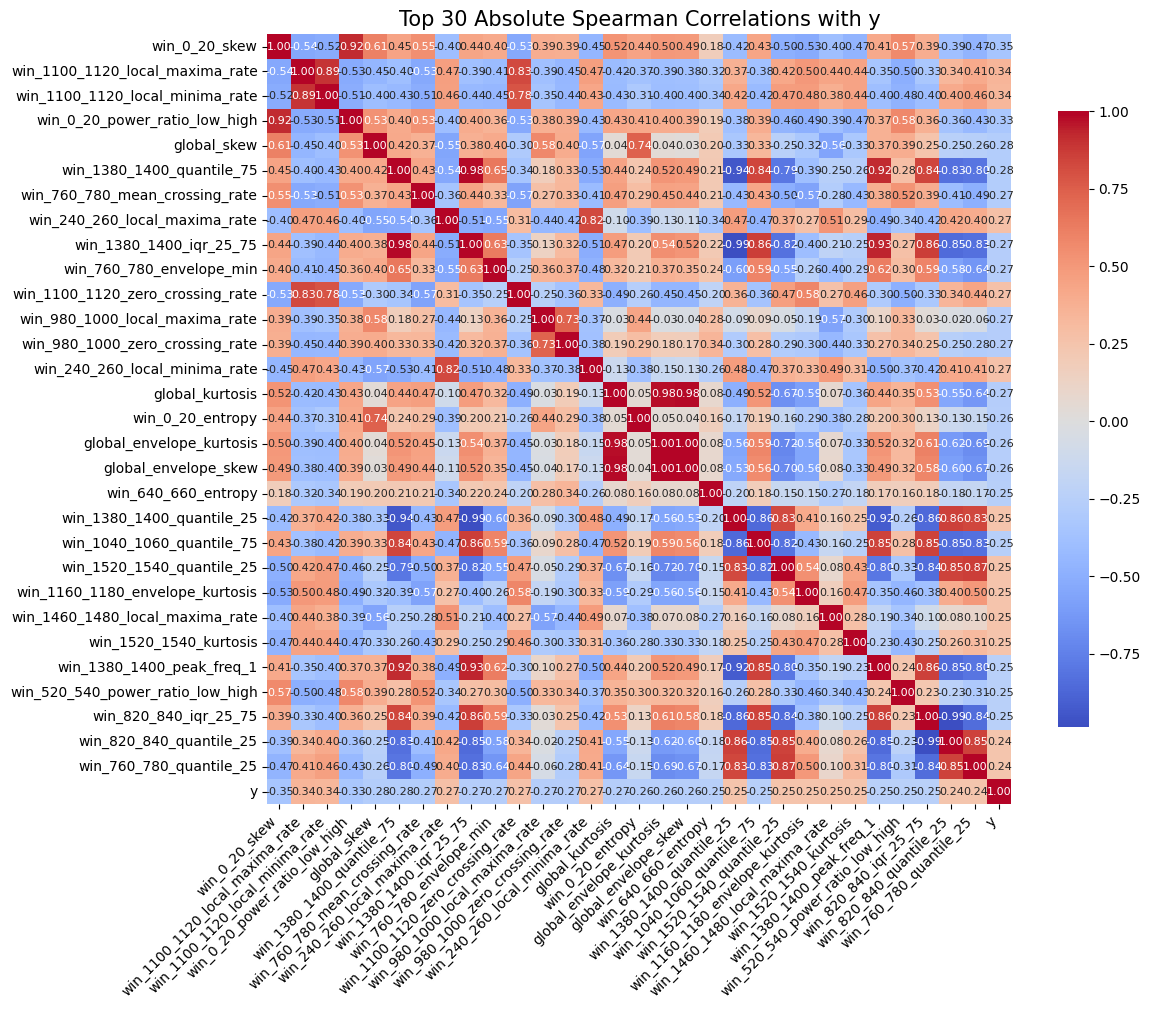

In [ ]:
#correlations wrt y target
all_dictionaries = {
    'augmented_features_continuous': augmented_features_continuous,
    'augmented_features_linear': augmented_features_linear,
    'augmented_features_cleaned': augmented_features_cleaned
}

top_correlations_dict = get_top_correlations_for_all(all_dictionaries, target_column='y', num_top=30)
summary_df = summarize_top_correlations(top_correlations_dict)
display_top_correlations_summary(summary_df, num_features=10)

#trend prediction

#feature extraction su raw data ok

#feature extraction con wavelet continua ok

#MAE, con visualizzazione del trend rispetto alle window originali

#provare con matrice hankeliana, e senza